In [1]:
using Plots;
gadfly();

In [2]:
include("../fdtd/update.jl");
include("../fdtd/sources.jl");
include("../fdtd/boundaries.jl");
using update;
using sources;

In [12]:
function simulate(n2)
   
    #Global parameters
    size = 100;
    endTime = 3000;

    # Incident
    inc_pos = 30;

    # Material
    n1 = 4;
    # n2 = sqrt(n1);

    eps1 = n1^2;
    eps2 = n2^2;

    wavelength = 16*n1
    #Grid

    # Magnetic
    hy = zeros(size-1);
    hy_0 = zeros(size-1);
    mu = ones(size-1);

    chyh = ones(size);
    chye = ones(size);


    # Electric
    ez = zeros(size);
    ez_0 = zeros(size);
    eps = ones(size) * eps1;
    eps_0 = ones(size) * eps1;

    cezh = ones(size);
    ceze = ones(size);

    for i in div(size, 2):div(size, 2)+(div(wavelength, 4))
        eps[i] = eps2;
    end

    rightBound = boundaries.setup_first_order_abc(eps, mu, size, true)
    leftBound = boundaries.setup_first_order_abc(eps, mu, 1, false)

    rightBound_0 = boundaries.setup_first_order_abc(eps_0, mu, size, true)
    leftBound_0 = boundaries.setup_first_order_abc(eps_0, mu, 1, false)

    # Time steps
    for time in 1:endTime
        # Incident
        ez_inc = sin(2*pi/(wavelength) * (time-1))

        # Magnetic      
        # Interior update
        update.update_magnetic_field!(ez, hy, mu, chyh, chye);    
        update.update_magnetic_field!(ez_0, hy_0, mu, chyh, chye);          

        # Electric     
        # Interior update
        update.update_electric_field!(ez, hy, eps, cezh, ceze);
        update.update_electric_field!(ez_0, hy_0, eps_0, cezh, ceze);    

        # ABC
        boundaries.first_order_diff_abc!(ez, leftBound)
        boundaries.first_order_diff_abc!(ez, rightBound)

        boundaries.first_order_diff_abc!(ez_0, leftBound_0)
        boundaries.first_order_diff_abc!(ez_0, rightBound_0)


        # Incident
        ez[inc_pos] += ez_inc / sqrt( eps[inc_pos] * mu[inc_pos])
        ez_0[inc_pos] += ez_inc / sqrt( eps[inc_pos] * mu[inc_pos])
    end
    return (ez-ez_0)[1:div(size, 2)]
end

simulate (generic function with 1 method)

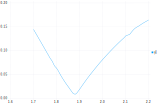

In [19]:
ran = linspace(1.7, 2.2, 200);
refl = zeros(200);
for i in 1:200
    h = simulate(ran[i]);
    refl[i] = maximum(abs(h))
end

plot(ran, refl)

In [22]:
f_min = 1.
n_fdtd = -1
for i in 1:200
    if refl[i] < f_min
        f_min = refl[i]
        n_fdtd = ran[i]
    end
end

n_analytic = 2.

err = abs(n_fdtd - n_analytic)/n_analytic
        
print("FDTD n = $n_fdtd\n")
print("Analtyic n = $n_analytic\n")
print("Error = $err%\n")

FDTD n = 1.8809045226130654
Analtyic n = 2.0
Error = 0.0595477386934673%
